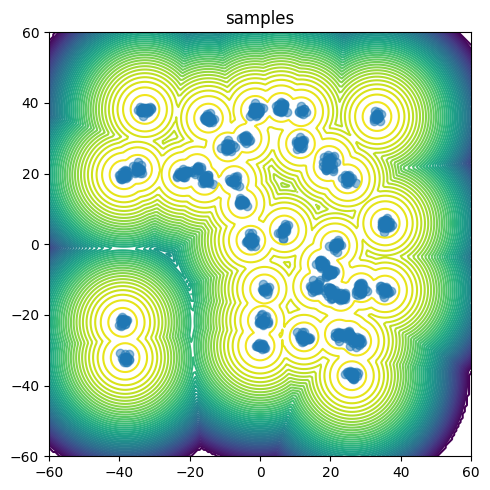

In [4]:
import jax 
import jax.numpy as jnp
import numpy as np
import distrax
from typing import Optional
import matplotlib.pyplot as plt
import itertools

# Taken from https://github.com/lollcat/fab-jax/blob/632e0a7d3dbd8da6b2ef043ab41e2346f29dfece/fabjax/utils/plot.py#L11
def plot_contours_2D(
    log_prob_func, ax: Optional[plt.Axes] = None, bound: int = 3, levels: int = 20
):
    """Plot the contours of a 2D log prob function."""
    if ax is None:
        fig, ax = plt.subplots(1)
    n_points = 200
    x_points_dim1 = np.linspace(-bound, bound, n_points)
    x_points_dim2 = np.linspace(-bound, bound, n_points)
    x_points = np.array(list(itertools.product(x_points_dim1, x_points_dim2)))
    log_probs = log_prob_func(x_points)
    log_probs = jnp.clip(log_probs, a_min=-1000, a_max=None)
    x1 = x_points[:, 0].reshape(n_points, n_points)
    x2 = x_points[:, 1].reshape(n_points, n_points)
    z = log_probs.reshape(n_points, n_points)
    ax.contour(x1, x2, z, levels=levels)


# Taken from https://github.com/lollcat/fab-jax/blob/632e0a7d3dbd8da6b2ef043ab41e2346f29dfece/fabjax/utils/plot.py#L30
def plot_marginal_pair(
    samples, ax=None, marginal_dims=(0, 1), bounds=(-5, 5), alpha: float = 0.5
):
    """Plot samples from marginal of distribution for a given pair of dimensions."""
    if not ax:
        fig, ax = plt.subplots(1)
    samples = jnp.clip(samples, bounds[0], bounds[1])
    ax.plot(
        samples[:, marginal_dims[0]], samples[:, marginal_dims[1]], "o", alpha=alpha
    )


def plot_gmm(samples, log_p_fn, loc_scaling):
    plot_bound = loc_scaling * 1.5
    fig, axs = plt.subplots(1, figsize=(5, 5))
    plot_marginal_pair(samples, axs, bounds=(-plot_bound, plot_bound))
    plot_contours_2D(log_p_fn, axs, bound=plot_bound, levels=50)
    axs.set_title("samples")
    plt.tight_layout()
    plt.show()

class GMM:
    def __init__(self, dim, n_mixes, loc_scaling, log_var_scaling=0.1, seed=0):
        self.seed = seed
        self.n_mixes = n_mixes
        self.dim = dim
        key = jax.random.PRNGKey(seed)
        logits = jnp.ones(n_mixes)
        mean = (
            jax.random.uniform(shape=(n_mixes, dim), key=key, minval=-1.0, maxval=1.0)
            * loc_scaling
        )
        log_var = np.ones(shape=(n_mixes, dim)) * log_var_scaling

        mixture_dist = distrax.Categorical(logits=logits)
        var = jax.nn.softplus(log_var)
        components_dist = distrax.Independent(
            distrax.Normal(loc=mean, scale=var), reinterpreted_batch_ndims=1
        )
        self.distribution = distrax.MixtureSameFamily(
            mixture_distribution=mixture_dist,
            components_distribution=components_dist,
        )

    def log_prob(self, x):
        log_prob = self.distribution.log_prob(x)

        # Can have numerical instabilities once log prob is very small. Manually override to prevent this.
        # This will cause the flow will ignore regions with less than 1e-4 probability under the target.
        valid_log_prob = log_prob > -1e4
        log_prob = np.where(valid_log_prob, log_prob, -jnp.inf * jnp.ones_like(log_prob))
        return log_prob

    def sample(self, seed, sample_shape):
        return self.distribution.sample(seed=seed, sample_shape=sample_shape)
    
gmm = GMM(dim=2, n_mixes=40, loc_scaling=40)

log_prob_model, dim, sample_from_target_fn = gmm.log_prob, 2, gmm.sample

target_samples = sample_from_target_fn(jax.random.PRNGKey(0), (1000,))

plot_gmm(
    target_samples,
    log_prob_model,
    40,
)

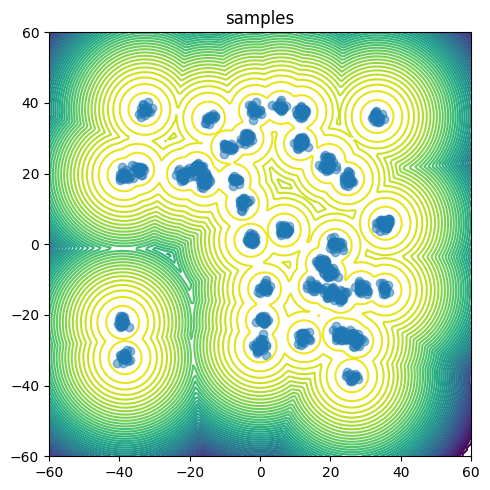

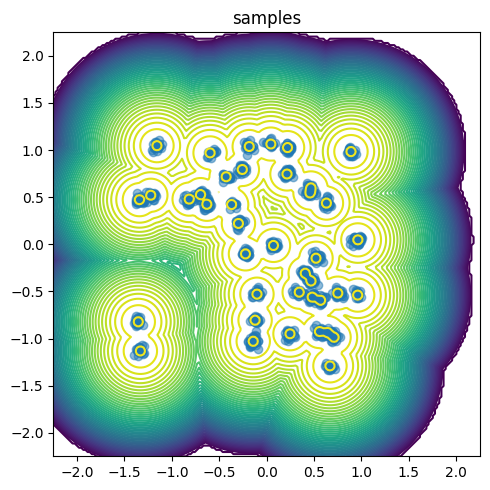

In [12]:
from datasets import GMM, MultiGMM

key = jax.random.PRNGKey(0)
n_mixes = 40
loc_scaling = 40.
log_var_scaling=0.1
prior = jnp.array([1./n_mixes]*n_mixes)

mean = (
    jax.random.uniform(shape=(n_mixes, 2), key=key, minval=-1.0, maxval=1.0)
    * loc_scaling
)
log_var = np.ones(shape=(n_mixes, 2)) * log_var_scaling
var = jax.nn.softplus(log_var)


gmm = MultiGMM(None, prior, mean, jnp.sqrt(var))
target_samples = gmm.generate_data(key, 1000)

plot_gmm(
    target_samples,
    lambda x : jnp.squeeze(gmm.log_density(x)),
    40,
)

prior_exp = jnp.expand_dims(prior, axis=-1)

mean_gmm = jnp.sum(prior_exp * mean, axis=0, keepdims=True)
var_gmm = jnp.sum(prior_exp * (var + jnp.square(mean))) - jnp.square(mean_gmm)
std_gmm = jnp.sqrt(var_gmm)

mean_new = (mean - mean_gmm)/std_gmm
var_new = var / var_gmm

gmm = MultiGMM(None, prior, mean_new, jnp.sqrt(var_new))
target_samples = gmm.generate_data(key, 1000)

plot_gmm(
    target_samples,
    lambda x : jnp.squeeze(gmm.log_density(x)),
    1.5,
)


In [2]:
import jax 
import jax.numpy as jnp
import numpy as np
import distrax
from typing import Optional
import matplotlib.pyplot as plt
import itertools
from datasets import GMM, MultiGMM
from jax.scipy.stats import norm, multivariate_normal
from schedulers import NoiseScheduler

noise_scheduler = NoiseScheduler()
gmm = GMM(noise_scheduler)
multi_gmm = MultiGMM(noise_scheduler)

print(gmm.density(jnp.array([[0.1]])))
print(multi_gmm.density(jnp.array([[0.1]])))

print(gmm.noisy_density(jnp.array([[0.1]]), 0.5))
print(multi_gmm.noisy_density(jnp.array([[0.1]]), 0.5))

print(gmm.log_density(jnp.array([[0.1]])))
print(multi_gmm.log_density(jnp.array([[0.1]])))

print(gmm.noisy_log_density(jnp.array([[0.1]]), 0.5))
print(multi_gmm.noisy_log_density(jnp.array([[0.1]]), 0.5))

print(gmm.score(jnp.array([[0.1]])))
print(multi_gmm.score(jnp.array([[0.1]])))

print(gmm.noisy_score(jnp.array([[0.1]]), 0.5))
print(multi_gmm.noisy_score(jnp.array([[0.1]]), 0.5))

print(gmm.score(jnp.array([[0.1]])))
print(multi_gmm.score(jnp.array([[0.1]])))

prior = jnp.array([0.5,0.5]), 
means = jnp.array([[-1., 0.],[1., 0.]])
stds = jnp.array([[0.2, 0.2],[0.2, 0.2]])
vars = jnp.square(stds) 

multivariate_normal.pdf(jnp.array([[0.1, 0.2],[0.2, 0.1]]), mean=means[0], cov=jnp.diag(vars[0]))

[[4.0228668e-05]]
[[4.022859e-05]]
[[0.34193224]]
[[0.34193224]]
[[-10.12093]]
[[-10.120932]]
[[-1.0731428]]
[[-1.0731425]]
[[22.165356]]
[[22.165356]]
[[-0.00852776]]
[[-0.00852782]]
[[22.165356]]
[[22.165356]]


Array([6.5149158e-07, 5.3477685e-08], dtype=float32)